# GAN Training

## imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json

from utils.loaders import load_safari
import pickle as pkl

from keras.models import load_model
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.merge import _Merge

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.initializers import RandomNormal


Using TensorFlow backend.


In [2]:
RUN_ID = '0029'
RUN_FOLDER = os.path.join("./run", RUN_ID)



## data

In [3]:
(x_train, y_train) = load_safari('camel')

## architecture

In [4]:
x_train.shape

(80000, 28, 28, 1)

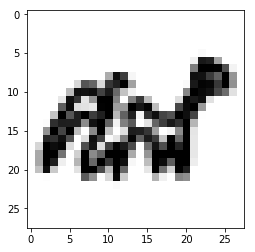

In [5]:
plt.imshow(x_train[200,:,:,0], cmap = 'gray_r')

In [6]:
np.min(x_train[0])

-1.0

## The discriminator

In [7]:
INPUT_DIM = (28,28,1)
discriminator_conv_filters = [64,64,128,128]
discriminator_conv_kernel_size = [5,5,5,5]
discriminator_conv_strides = [2,2,2,1]
discriminator_kernel_initializer = RandomNormal(mean=0., stddev=0.02)

discriminator_input = Input(shape=INPUT_DIM, name='discriminator_input')
x = discriminator_input

for i in range(len(discriminator_conv_filters)):

    x = Conv2D(
        filters = discriminator_conv_filters[i]
        , kernel_size = discriminator_conv_kernel_size[i]
        , strides = discriminator_conv_strides[i]
        , padding = 'same'
        , name = 'discriminator_conv_' + str(i)
        , kernel_initializer = discriminator_kernel_initializer
        )(x)

    x = Activation('relu')(x)
    x = Dropout(rate = 0.4)(x)

x = Flatten()(x)
x = Dense(1, kernel_initializer = discriminator_kernel_initializer)(x)
discriminator_output = Activation('sigmoid')(x)

discriminator = Model(discriminator_input, discriminator_output)

In [8]:
z_dim = 100

generator_initial_dense_layer_size = (7, 7, 64)
generator_upsample = [2,2, 1, 1]
generator_conv_filters = [128,64, 64,1]
generator_conv_kernel_size = [5,5,5,5]
generator_kernel_initializer = RandomNormal(mean=0., stddev=0.02)

n_layers_generator = len(generator_conv_filters)

generator_input = Input(shape=(z_dim,), name='generator_input')
x = generator_input

x = Dense(np.prod(generator_initial_dense_layer_size), kernel_initializer = generator_kernel_initializer)(generator_input)
x = BatchNormalization(momentum = 0.9)(x)
x = Activation('relu')(x)

x = Reshape(generator_initial_dense_layer_size)(x)

for i in range(n_layers_generator):

    if generator_upsample[i] == 2:
        x = UpSampling2D()(x)
    x = Conv2D(
        filters = generator_conv_filters[i]
        , kernel_size = generator_conv_kernel_size[i]
        , padding = 'same'
        , name = 'generator_conv_' + str(i)
        , kernel_initializer = generator_kernel_initializer
        )(x)

    if i < n_layers_generator - 1:
        x = BatchNormalization(momentum = 0.9)(x)
        x = Activation('relu')(x)
    else:
        x = Activation('tanh')(x)


generator_output = x
generator = Model(generator_input, generator_output)

In [9]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 28, 28, 1)         0         
_________________________________________________________________
discriminator_conv_0 (Conv2D (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
discriminator_conv_1 (Conv2D (None, 7, 7, 64)          102464    
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
__________

In [10]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_6 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 14, 14, 128)       204928    
__________

## compile

In [11]:
### COMPILE DISCRIMINATOR

discriminator.compile(
    optimizer= RMSprop(lr=0.0008)
    , loss = 'binary_crossentropy'
    ,  metrics = ['accuracy']
)

### COMPILE COMBINED MODEL

discriminator.trainable = False
model_input = Input(shape=(z_dim,), name='model_input')
model_output = discriminator(generator(model_input))
model = Model(model_input, model_output)

model.compile(
    optimizer=RMSprop(lr=0.0004) 
    , loss='binary_crossentropy'
    , metrics=['accuracy']
)

discriminator.trainable = True

## training

In [12]:
def train_discriminator(x_train, batch_size):

    valid = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    true_imgs = x_train[idx]

    noise = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(noise)

    d_loss_real, d_acc_real =   discriminator.train_on_batch(true_imgs, valid)
    d_loss_fake, d_acc_fake =   discriminator.train_on_batch(gen_imgs, fake)

    d_loss =  0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]

def train_generator(batch_size):
    valid = np.ones((batch_size,1))
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    return model.train_on_batch(noise, valid)

In [13]:
epochs = 2000
batch_size = 64

for epoch in range(epochs):

    d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake = train_discriminator(x_train, batch_size)
    g_loss, g_acc = train_generator(batch_size)

    # Plot the progress
    print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake, g_loss, g_acc))

/Users/davidfoster/.virtualenvs/gdl/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: (0.732)(R 0.688, F 0.777)] [D acc: (0.312)(0.625, 0.000)] [G loss: 0.674] [G acc: 1.000]
1 [D loss: (1.784)(R 0.643, F 2.924)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.679] [G acc: 1.000]
2 [D loss: (0.695)(R 0.676, F 0.714)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.678] [G acc: 1.000]
3 [D loss: (0.694)(R 0.675, F 0.713)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.678] [G acc: 1.000]
4 [D loss: (0.692)(R 0.674, F 0.710)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.677] [G acc: 1.000]
5 [D loss: (0.693)(R 0.673, F 0.714)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.677] [G acc: 1.000]
6 [D loss: (0.692)(R 0.670, F 0.713)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.678] [G acc: 1.000]
7 [D loss: (0.690)(R 0.665, F 0.715)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.678] [G acc: 1.000]
8 [D loss: (0.686)(R 0.654, F 0.719)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.679] [G acc: 1.000]


KeyboardInterrupt: 